# Train RASCAL ensemble

Johann Brehmer, Kyle Cranmer, Marco Farina, Felix Kling, Duccio Pappadopulo, Josh Ruderman 2018

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import logging
import os
%load_ext line_profiler
from torch.autograd import profiler
from torchviz import make_dot

from madminer.sampling import SampleAugmenter
from madminer.sampling import multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge
from madminer.utils.ml.ratio_trainer import train_ratio_model
from madminer.utils.ml.models.ratio import ParameterizedRatioEstimator


In [2]:
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.WARNING
)

for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [3]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_4/'

In [4]:
sample_dir = base_dir + 'data/samples/wgamma_sys/'
card_dir = base_dir + 'cards/wgamma/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma_sys/'
log_dir = base_dir + 'logs/wgamma_sys/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'
model_dir = base_dir + 'data/models/wgamma_sys/'

## Calculate computational graph

In [5]:
ml = MLForge()

cut_label = '_tight'

loss_rolr, params_rolr = ml.train(
    method='rolr',
    x_filename=sample_dir + 'train_ratio_tight/x_train_0.npy',
    theta0_filename=sample_dir + 'train_ratio_tight/theta0_train_0.npy',
    t_xz0_filename=sample_dir + 'train_ratio_tight/t_xz_train_0.npy',
    r_xz_filename=sample_dir + 'train_ratio_tight/r_xz_train_0.npy',
    y_filename=sample_dir + 'train_ratio_tight/y_train_0.npy',
    limit_samplesize=2,
    batch_size=2,
    return_first_loss=True
)

loss, params = ml.train(
    method='rascal',
    x_filename=sample_dir + 'train_ratio_tight/x_train_0.npy',
    theta0_filename=sample_dir + 'train_ratio_tight/theta0_train_0.npy',
    t_xz0_filename=sample_dir + 'train_ratio_tight/t_xz_train_0.npy',
    r_xz_filename=sample_dir + 'train_ratio_tight/r_xz_train_0.npy',
    y_filename=sample_dir + 'train_ratio_tight/y_train_0.npy',
    limit_samplesize=2,
    batch_size=2,
    return_first_loss=True
)

## ROLR graph

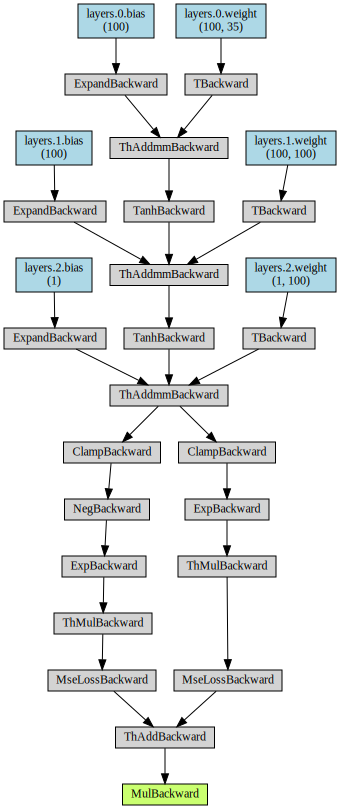

In [6]:
make_dot(loss_rolr, params=params_rolr)

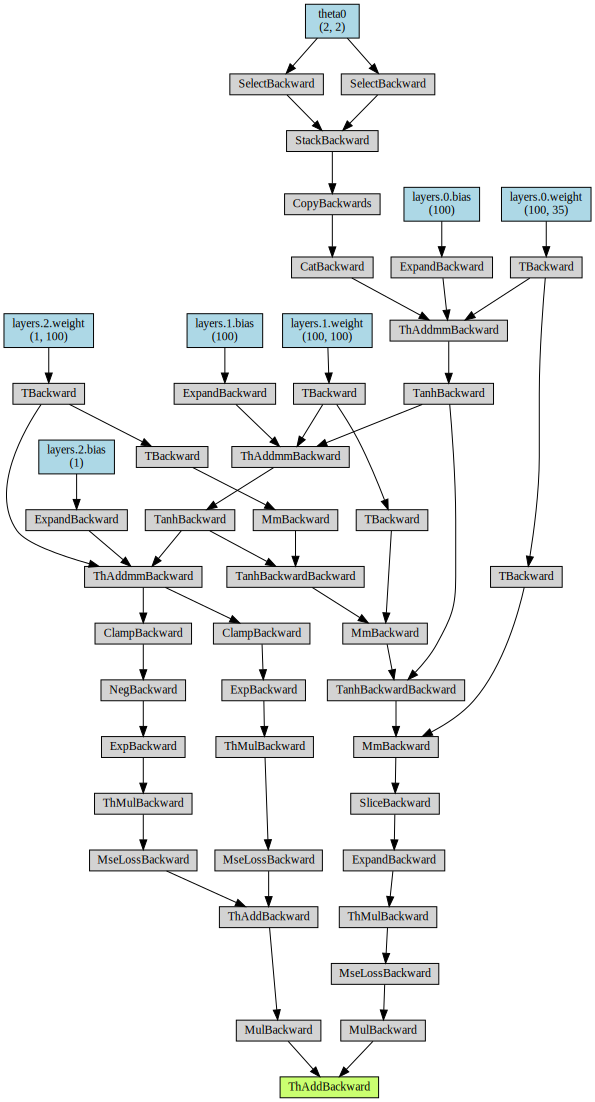

In [7]:
make_dot(loss, params=params)

## Profiling

In [13]:
def train(**kwargs):
    cut_label = '_tight'
    EnsembleForge(estimators=1).train_all(
        method='rascal',
        x_filename=[sample_dir + 'train_ratio{}/x_train_{}.npy'.format(cut_label, i) for i in range(1)],
        theta0_filename=[sample_dir + 'train_ratio{}/theta0_train_{}.npy'.format(cut_label, i) for i in range(1)],
        t_xz0_filename=[sample_dir + 'train_ratio{}/t_xz_train_{}.npy'.format(cut_label, i) for i in range(1)],
        r_xz_filename=[sample_dir + 'train_ratio{}/r_xz_train_{}.npy'.format(cut_label, i) for i in range(1)],
        y_filename=[sample_dir + 'train_ratio{}/y_train_{}.npy'.format(cut_label, i) for i in range(1)],
        **kwargs
    )

In [21]:
%lprun -f ParameterizedRatioEstimator.forward train(n_epochs=1, limit_samplesize=10000, batch_size=500)


In [19]:
with profiler.profile() as prof:
    train(n_epochs=1, limit_samplesize=2000, batch_size=500)


In [20]:
print(prof.table(sort_by='cpu_time'))

-----------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------
Name                                        CPU time        CUDA time            Calls        CPU total       CUDA total
-----------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------
is_floating_point                            0.063us          0.000us                1          0.063us          0.000us
is_floating_point                            0.064us          0.000us                1          0.064us          0.000us
is_floating_point                            0.064us          0.000us                1          0.064us          0.000us
is_floating_point                            0.064us          0.000us                1          0.064us          0.000us
is_floating_point                            0.064us          0.000us                1          0.064us          0.000us
is_floating_point               